# Unsupervised learning

Import usefull packages + the njord library. For installations details please refer to README file. 

In [41]:
import njord as nj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hyper parameters

In [42]:
# Dataset parameters.
PATH = "dataset"
SYMBOL = "btcusdt"
DATASET = "ohlc"
PERIOD = 600
FILENAME_TR = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "train")
FILENAME_TE = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "test")

# Batch parameters.
LOOKBACK = 16
LOOKAHEAD = 1
TARGET = "close"

# Training parameters.
LR = 0.0001
EPOCHS = 100
MINIBATCH_SIZE = 128

## Dataset

Load the dataset from .csv file to a pandas dataframe.

In [43]:
# Load the training dataset.
data_tr = pd.read_csv(PATH + "/" + FILENAME_TR)
data_tr = data_tr.set_index("time")
data_tr.index = pd.to_datetime(data_tr.index)

# Load the test dataset.
data_te = pd.read_csv(PATH + "/" + FILENAME_TE)
data_te = data_te.set_index("time")
data_te.index = pd.to_datetime(data_te.index)

In [44]:
# Display the number of samples for the datasets.
print("Number of samples train = {}".format(data_tr.shape))
print("Number of samples test = {}".format(data_te.shape))

# Display the head of the dataset.
print("\n training head: \n{}".format(data_tr.head()))
print("\n test head: \n{}".format(data_te.head()))

Number of samples train = (8784, 5)
Number of samples test = (2736, 5)

 training head: 
                        open     high      low    close          avg
time                                                                
2018-09-01 00:10:00  7011.21  7044.35  7010.00  7041.65  7029.350052
2018-09-01 00:20:00  7041.87  7041.87  7031.82  7038.41  7037.445636
2018-09-01 00:30:00  7038.41  7046.00  7034.72  7046.00  7041.031830
2018-09-01 00:40:00  7046.00  7049.00  7036.28  7043.81  7044.063838
2018-09-01 00:50:00  7045.42  7046.33  7030.05  7030.05  7038.251102

 test head: 
                        open     high      low    close          avg
time                                                                
2018-11-01 00:10:00  6371.93  6376.99  6369.57  6375.15  6374.240114
2018-11-01 00:20:00  6375.19  6376.98  6372.19  6374.48  6374.350265
2018-11-01 00:30:00  6373.21  6375.00  6360.77  6366.25  6368.364441
2018-11-01 00:40:00  6366.56  6366.80  6355.00  6355.17  6361.868075


## Batch and data normalisation

We now have to build the batch, i.e. a feature array X with its associated targets Y. 

- The timeseries X are normalise with the pivot method.

In [72]:
# Load the training and test batch.
batch_tr = nj.Batch(data_tr, LOOKBACK, LOOKAHEAD)
batch_te = nj.Batch(data_te, LOOKBACK, LOOKAHEAD)

# Build the training and test batch to get the features and the targets.
X_tr, _ = batch_tr.build(target="avg", method=None)
X_te, _ = batch_te.build(target="avg", method=None)

# Function to normalise the data.
def normalise(X):
    U = X.max(axis=(1, 2), keepdims=True)
    L = X.min(axis=(1, 2), keepdims=True)
    return ( 2 * X - U - L ) / ( U - L + 1.0E-8 )

# Normalise the data.
X_tr = normalise(X_tr)
X_te = normalise(X_te)

In [73]:
# Display features information.
print("\nTraining Features info:")
print("X_tr shape = {}".format(X_tr.shape))
print("X_tr mean  = {}".format(X_tr.mean()))
print("X_tr std   = {}".format(X_tr.std()))
print("\nTest Features info:")
print("X_te shape = {}".format(X_te.shape))
print("X_te mean  = {}".format(X_te.mean()))
print("X_te std   = {}".format(X_te.std()))


Training Features info:
X_tr shape = (8751, 16, 5)
X_tr mean  = 0.027979945489454174
X_tr std   = 0.4991679652084889

Test Features info:
X_te shape = (2669, 16, 5)
X_te mean  = 0.022975271114086978
X_te std   = 0.5054799041297846


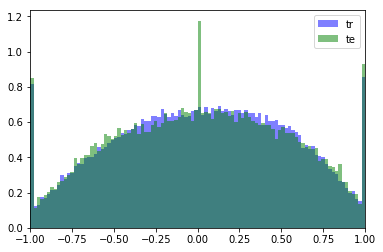

In [78]:
# Histogram: Train and test Features.
hist_X_tr = plt.hist(X_tr.reshape(-1, 1), 100, density=True, facecolor="b", alpha=0.50, label="tr")
hist_X_te = plt.hist(X_te.reshape(-1, 1), 100, density=True, facecolor="g", alpha=0.50, label="te")
plt.xlim([-1, 1])
plt.legend()
plt.show()

## Training

Train a model with keras.

In [80]:
# Import usefull packages.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
import keras.backend as K

In [81]:
# Reshape the training dataset.
X_train = X_tr.reshape(X_tr.shape[0], -1)

# Reshape the test dataset.
X_test = X_te.reshape(X_te.shape[0], -1)

# Build the model.
model = Sequential()
model.add(Dense(units=128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(units=64,  activation="relu"))
model.add(Dense(units=32,  activation="linear"))
model.add(Dense(units=64,  activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=X_train.shape[1], activation="linear"))

# Set the optimizer.
optimizer = optimizers.Adam(lr=0.001, epsilon=1.0E-6, decay=0.0)

# Compile the model.
model.compile(loss="mean_squared_error", optimizer=optimizer)

# Set the training parameters.
params = {
    "epochs": 200,
    "batch_size": 32,
    "validation_data": (X_test, X_test),
    "shuffle": True,
    "verbose": 1
}

# Train the model.
history = model.fit(X_train, X_train, **params)

# Training finished.
print("Training finished")

Train on 8751 samples, validate on 2669 samples
Epoch 1/200
8751/8751 [==============================] - 1s 114us/step - loss: 0.0534 - val_loss: 0.0221
Epoch 2/200
8751/8751 [==============================] - 1s 67us/step - loss: 0.0180 - val_loss: 0.0154
Epoch 3/200
8751/8751 [==============================] - 1s 67us/step - loss: 0.0136 - val_loss: 0.0124
Epoch 4/200
8751/8751 [==============================] - 1s 68us/step - loss: 0.0112 - val_loss: 0.0104
Epoch 5/200
8751/8751 [==============================] - 1s 68us/step - loss: 0.0096 - val_loss: 0.0092
Epoch 6/200
8751/8751 [==============================] - 1s 68us/step - loss: 0.0087 - val_loss: 0.0084
Epoch 7/200
8751/8751 [==============================] - 1s 69us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/200
8751/8751 [==============================] - 1s 69us/step - loss: 0.0075 - val_loss: 0.0073
Epoch 9/200
8751/8751 [==============================] - 1s 69us/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/200
87

8751/8751 [==============================] - 1s 92us/step - loss: 0.0042 - val_loss: 0.0045
Epoch 79/200
8751/8751 [==============================] - 1s 71us/step - loss: 0.0041 - val_loss: 0.0048
Epoch 80/200
8751/8751 [==============================] - 1s 76us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 81/200
8751/8751 [==============================] - 1s 80us/step - loss: 0.0041 - val_loss: 0.0043
Epoch 82/200
8751/8751 [==============================] - 1s 83us/step - loss: 0.0042 - val_loss: 0.0045
Epoch 83/200
8751/8751 [==============================] - 1s 95us/step - loss: 0.0041 - val_loss: 0.0047
Epoch 84/200
8751/8751 [==============================] - 1s 93us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 85/200
8751/8751 [==============================] - 1s 124us/step - loss: 0.0041 - val_loss: 0.0045
Epoch 86/200
8751/8751 [==============================] - 1s 78us/step - loss: 0.0041 - val_loss: 0.0047
Epoch 87/200
8751/8751 [==============================] - 1s 80us/s

8751/8751 [==============================] - 1s 67us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 156/200
8751/8751 [==============================] - 1s 65us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 157/200
8751/8751 [==============================] - 1s 66us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 158/200
8751/8751 [==============================] - 1s 66us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 159/200
8751/8751 [==============================] - 1s 64us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 160/200
8751/8751 [==============================] - 1s 65us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 161/200
8751/8751 [==============================] - 1s 67us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 162/200
8751/8751 [==============================] - 1s 67us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 163/200
8751/8751 [==============================] - 1s 65us/step - loss: 0.0039 - val_loss: 0.0041
Epoch 164/200
8751/8751 [==============================] - 1

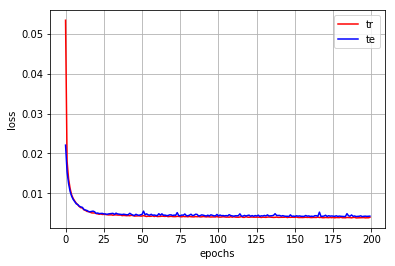

In [82]:
# Figure: loss vs epochs.
plt.figure()
plt.plot(history.history["loss"], label="tr", color="r")
plt.plot(history.history["val_loss"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

## Evaluation of the model

In [83]:
# Evaluate the model on th train set.
eval_tr = model.evaluate(X_train, X_train, verbose=2)

# Evaluate the model on th test set.
eval_te = model.evaluate(X_test, X_test, verbose=2)

# Display the results.
print("Evaluate model on the training set: \n {}".format(eval_tr))
print("Evaluate model on the test set: \n {}".format(eval_te))

Evaluate model on the training set: 
 0.0038290636223067102
Evaluate model on the test set: 
 0.004241317988391833


In [84]:
# The number of sequences to display.
n = 1

# Get the predictions of the model.
X_te_p = model.predict(X_test)

# Reshape the features and predictions.
X_te_s = X_test.reshape(X_test.shape[0], LOOKBACK, -1)
X_te_p = X_te_p.reshape(X_test.shape[0], LOOKBACK, -1)

Maximum error = 0.19310650459564732, index = 1830
Minimum error = 0.011611622007763401, index = 1833


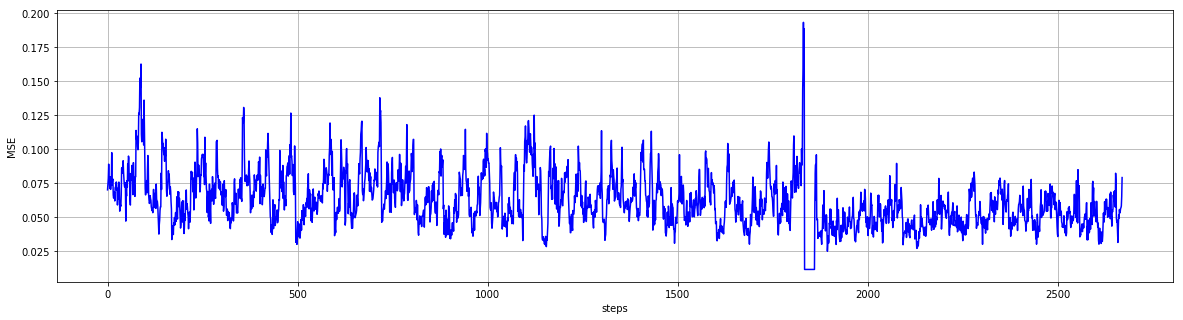

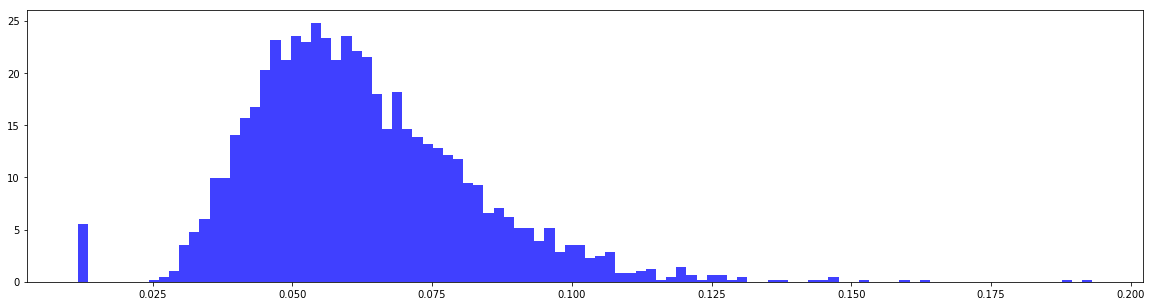

In [85]:
# Compute the residuals.
res = ( X_te_s - X_te_p)

# Compute the average error.
err = np.sqrt(np.mean( res * res, axis=(1, 2)))

# Compute the maximum and minimum error.
err_max = err.max()
err_min = err.min()
err_amax = err.argmax()
err_amin = err.argmin()
print("Maximum error = {}, index = {}".format(err_max, err_amax))
print("Minimum error = {}, index = {}".format(err_min, err_amin))

# Figure 1: MSE vs. steps.
plt.figure(figsize=(20, 5))
plt.plot(err, color="b")
plt.xlabel("steps")
plt.ylabel("MSE")
plt.grid()
plt.show()

# Figure 2: MSE histograme
plt.figure(figsize=(20, 5))
histogram = plt.hist(err, 100, density=True, facecolor="b", alpha=0.75, label="te")
plt.show()

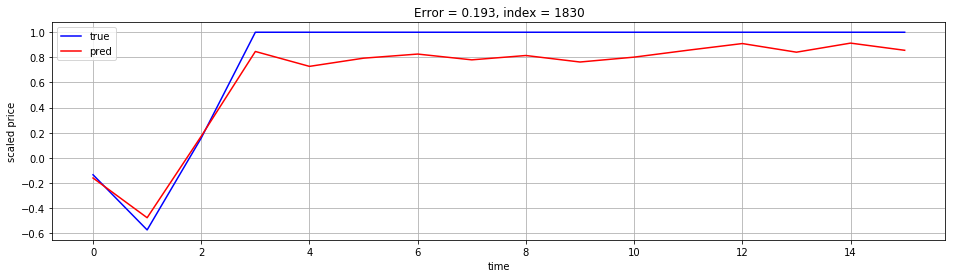

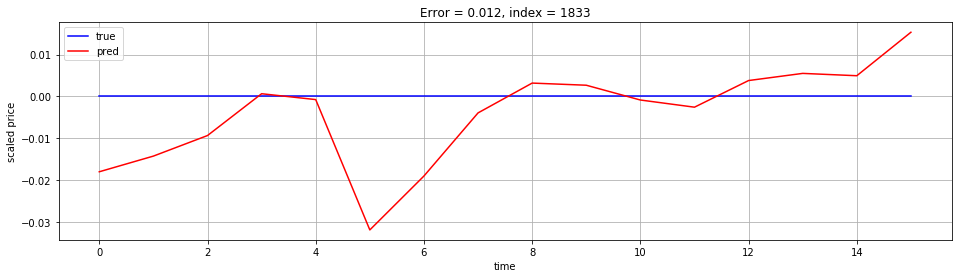

In [99]:
# Figure 3: Worst case.
plt.figure(figsize=(16, 4))
plt.plot(X_te_s[err_amax,:,4], color="b", label="true")
plt.plot(X_te_p[err_amax,:,4], color="r", label="pred")
plt.xlabel("time")
plt.ylabel("scaled price")
plt.title("Error = {}, index = {}".format(round(err_max, 3), err_amax))
plt.legend()
plt.grid()
plt.show()

# Figure 4: Best case.
plt.figure(figsize=(16, 4))
plt.plot(X_te_s[err_amin,:,4], color="b", label="true")
plt.plot(X_te_p[err_amin,:,4], color="r", label="pred")
plt.xlabel("time")
plt.ylabel("scaled price")
plt.title("Error = {}, index = {}".format(round(err_min, 3), err_amin))
plt.legend()
plt.grid()
plt.show()